### Cell type composition analysis - scCODA

Following vignette https://sccoda.readthedocs.io/en/latest/getting_started.html

In [1]:
import sccoda

In [2]:
import os,sys
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.sparse
import anndata

In [3]:
## import utils
cwd = '/nfs/team205/ed6/bin/Pan_fetal_immune/utils/'
sys.path.append(cwd)

import genes
import panfetal_utils

# import ti_utils

In [6]:
from sccoda.util import comp_ana as mod
from sccoda.util import cell_composition_data as dat
from sccoda.util import data_visualization as viz

In [111]:
import anndata2ri
import rpy2.rinterface_lib.callbacks
import logging

In [112]:
# Ignore R warning messages
#Note: this can be commented out to get more verbose R output
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

Activate the anndata2ri conversion between SingleCellExperiment and AnnData

In [113]:
anndata2ri.activate()

In [114]:
%load_ext rpy2.ipython

In [115]:
%%R
library(tidyverse)

### Load data and annotations

In [4]:
adata_lymph = panfetal_utils._load_split_and_annotation("LYMPHOID")

/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3337: DtypeWarning: Columns (9) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


### Make celltype count matrix 
Per sample

In [42]:
metadata_df = adata_lymph.obs[["anno_lvl_2", "organ", "age", "Sample", "Sort_id"]]
metadata_df = metadata_df[~metadata_df.anno_lvl_2.isna()]

## Make obs for pseudobulk
group_by = ["Sample", "anno_lvl_2"]
pseudobulk_obs = metadata_df[group_by].drop_duplicates()
pseudobulk_obs.index = pseudobulk_obs[group_by].agg("-".join, axis=1)

metadata_df["pseudobulk_sample"] = metadata_df[group_by].agg("-".join, axis=1)

## Add number of cells to obs 
n_cells = metadata_df.groupby('pseudobulk_sample').count().iloc[:,0]
n_cells.name = "n_cells"
pseudobulk_obs = pd.concat([pseudobulk_obs, n_cells], axis=1)

cell_counts = pseudobulk_obs[["Sample",'anno_lvl_2',"n_cells"]].pivot(index='Sample', columns="anno_lvl_2", values="n_cells").fillna(0)
cell_counts = cell_counts.reset_index()

In [43]:
cell_counts.index = cell_counts["Sample"]

In [44]:
## Match sample 2 covariates
sample2cov = metadata_df[["Sample", "organ", "age", "Sort_id"]].drop_duplicates()
sample2cov.index = sample2cov.Sample

cell_counts = pd.concat([cell_counts, sample2cov], 1)


Convert 2 anndata

In [45]:
# Convert data to anndata object
data_all = dat.from_pandas(cell_counts, covariate_columns=["organ", "Sample", "Sort_id", "age"])

/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/anndata/_core/anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [78]:
data_all.obs.loc[data_all.obs["organ"] == 'TH(pharyn)', "organ"]  = "TH"

<AxesSubplot:xlabel='Cell type', ylabel='Proportion'>

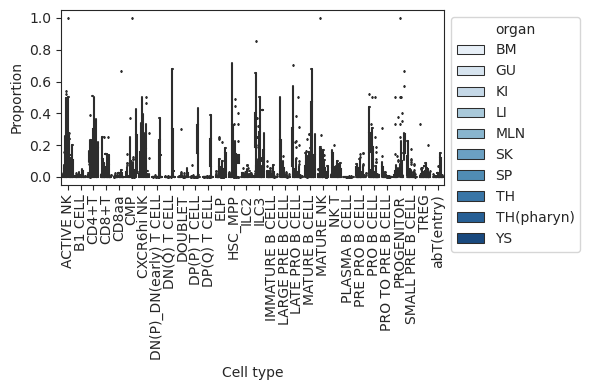

In [48]:
viz.boxplots(data_all, feature_name="organ")

### Select celltypes of interest

In [71]:
import matplotlib

<module 'matplotlib.colors' from '/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/matplotlib/colors.py'>

<AxesSubplot:ylabel='organ'>

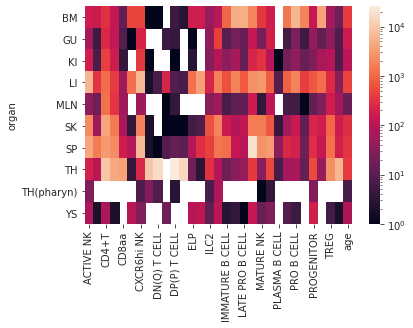

In [80]:
sns.heatmap(cell_counts.groupby('organ').sum(), norm=matplotlib.colors.LogNorm())

In [272]:
data_all[data_all.obs['Sort_id'] == 'TOT'].obs.value_counts("organ")

organ
TH    9
YS    7
GU    5
LI    4
BM    2
SP    2
dtype: int64

/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


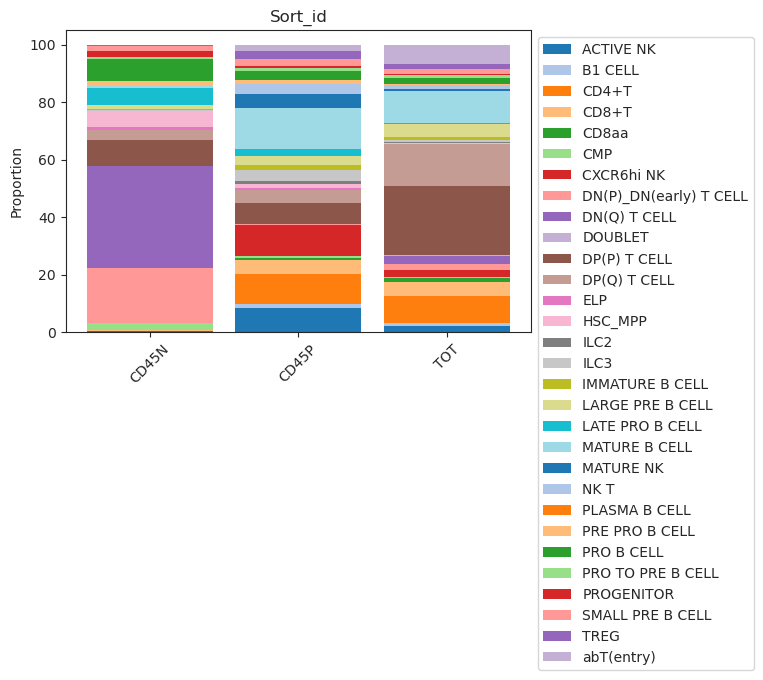

In [179]:
data_all.obs.loc[data_all.obs["Sort_id"] == "CD45P_CD45N", "Sort_id"] = "CD45P"

keep_sorts = ["CD45P", "CD45N", 'TOT']

viz.stacked_barplot(data_all[data_all.obs['Sort_id'].isin(keep_sorts)], feature_name="Sort_id")
plt.show()

In [166]:
data_sorts = data_all[data_all.obs['Sort_id'].isin(keep_sorts)]

In [262]:
NK_clusters = [x for x in data_all.var_names if x.endswith("NK")]
B_clusters = [x for x in data_all.var_names if x.endswith("B CELL")]
T_clusters = [x for x in data_all.var_names if x.endswith("T CELL")] + ["TREG", "CD4+T", 'CD8+T', "NK T"]

In [307]:
o="LI"
data_all[data_all.obs["organ"]==o].obs.age.astype("int").sort_values().unique().tolist()

[7, 8, 9, 10, 11, 12, 14, 16, 17]

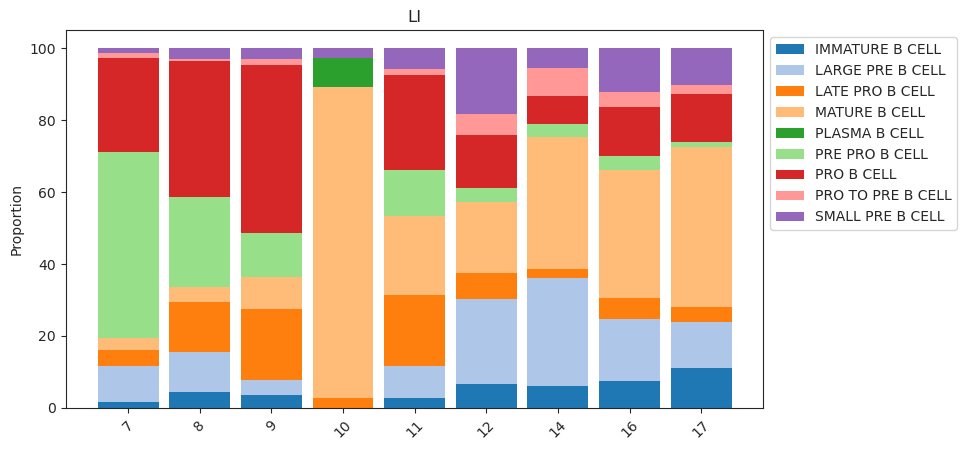

/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


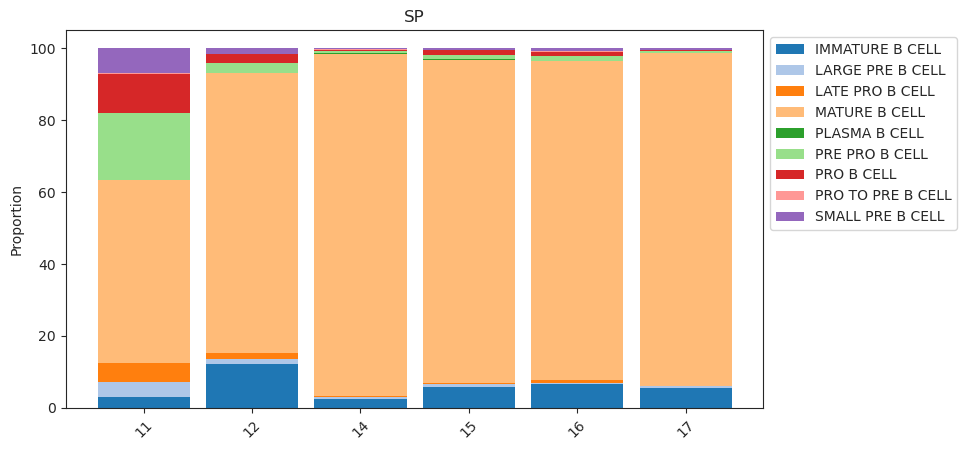

/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


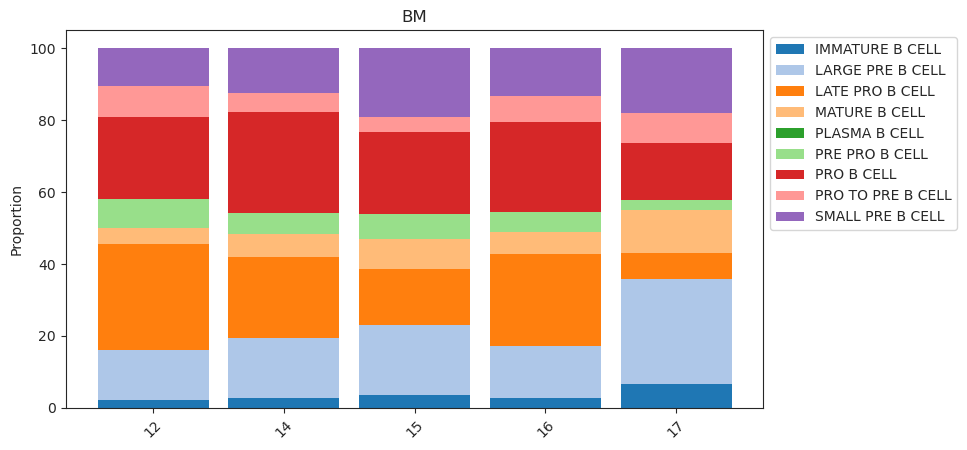

/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/sccoda/util/data_visualization.py:77: RuntimeWarning: invalid value encountered in double_scalars
  bars = [i / j * 100 for i, j in zip([y[k][n] for k in range(n_bars)], sample_sums)]


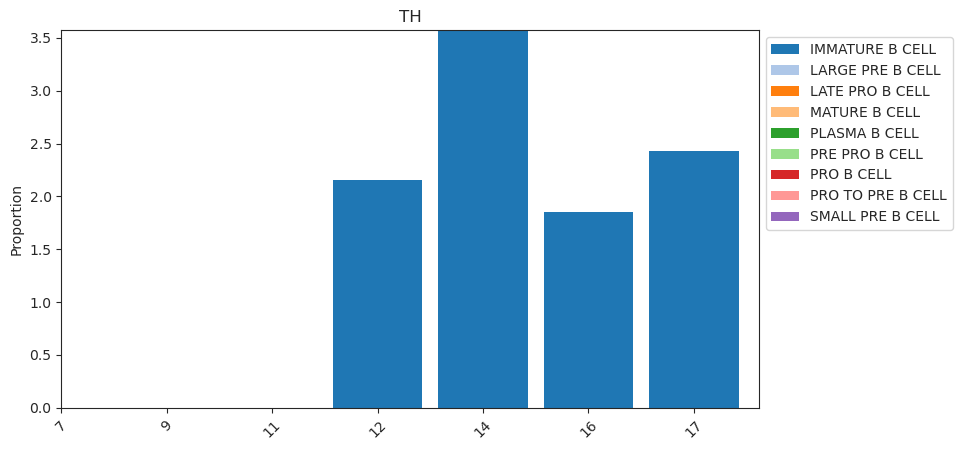

/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/sccoda/util/data_visualization.py:77: RuntimeWarning: invalid value encountered in double_scalars
  bars = [i / j * 100 for i, j in zip([y[k][n] for k in range(n_bars)], sample_sums)]


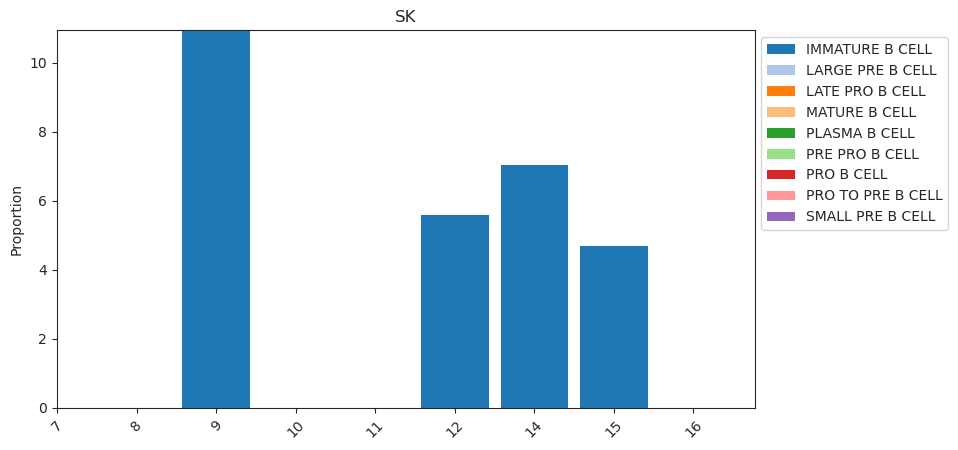

/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


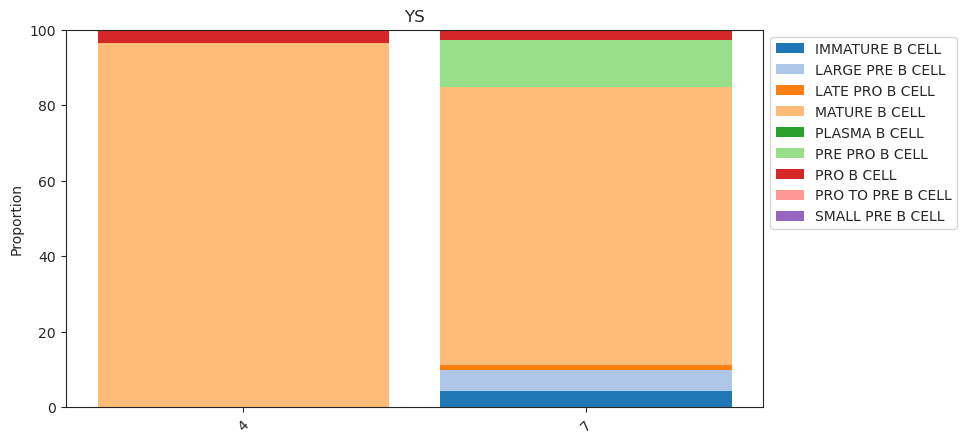

/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/sccoda/util/data_visualization.py:77: RuntimeWarning: invalid value encountered in double_scalars
  bars = [i / j * 100 for i, j in zip([y[k][n] for k in range(n_bars)], sample_sums)]


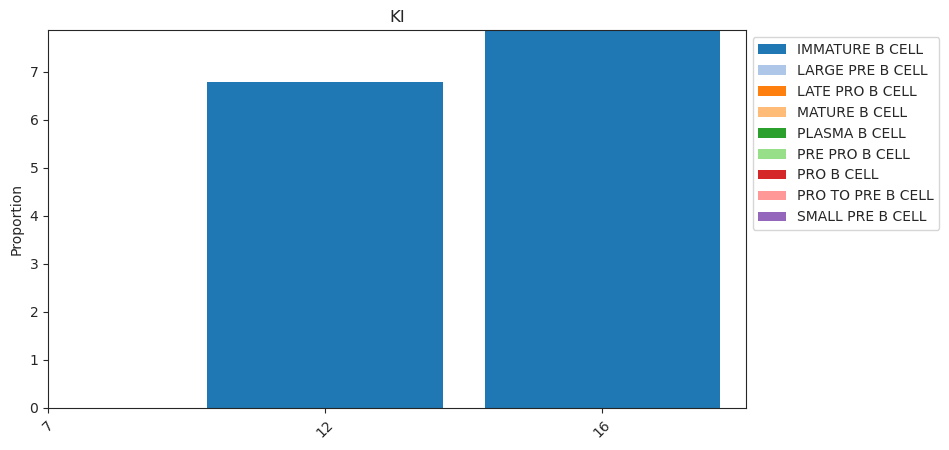

/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/sccoda/util/data_visualization.py:77: RuntimeWarning: invalid value encountered in double_scalars
  bars = [i / j * 100 for i, j in zip([y[k][n] for k in range(n_bars)], sample_sums)]


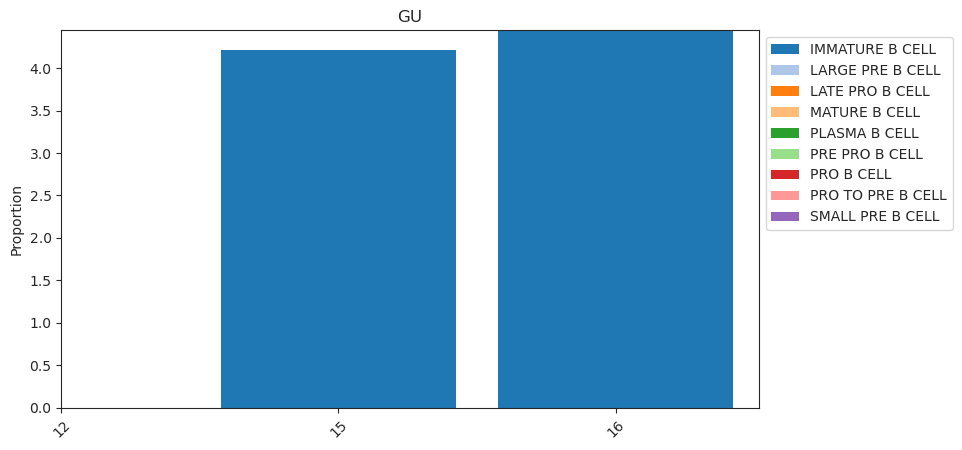

/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


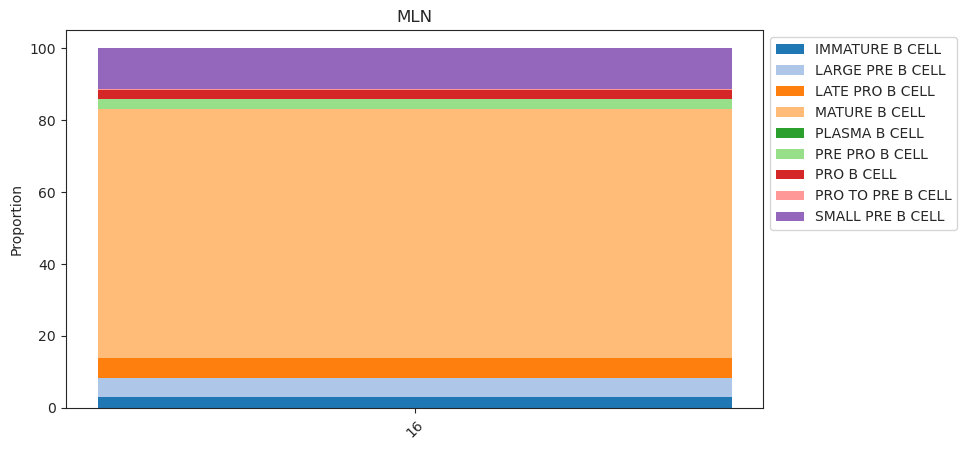

In [313]:
for o in data_all.obs["organ"].unique():
    lvls = data_all[data_all.obs["organ"]==o].obs.age.astype("int").sort_values().unique()
    viz.stacked_barplot(data_all[data_all.obs["organ"]==o][:,B_clusters], feature_name="age", level_order=lvls.tolist());
    plt.title(o);
    plt.show()

/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


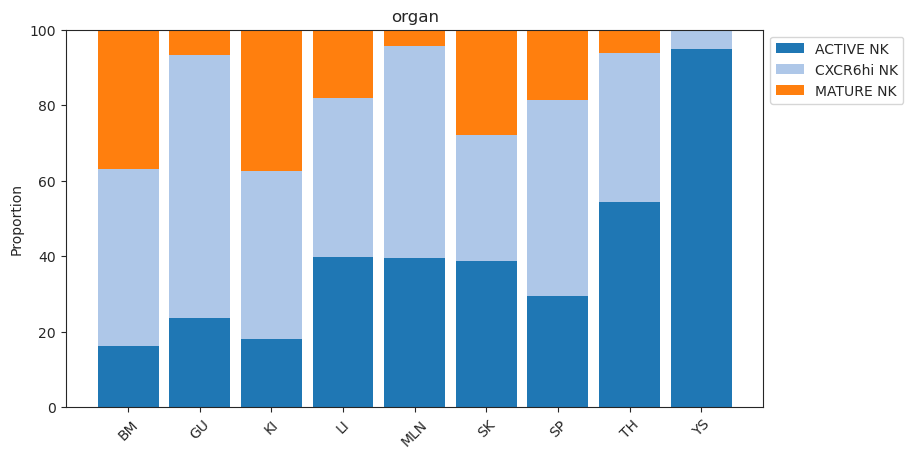

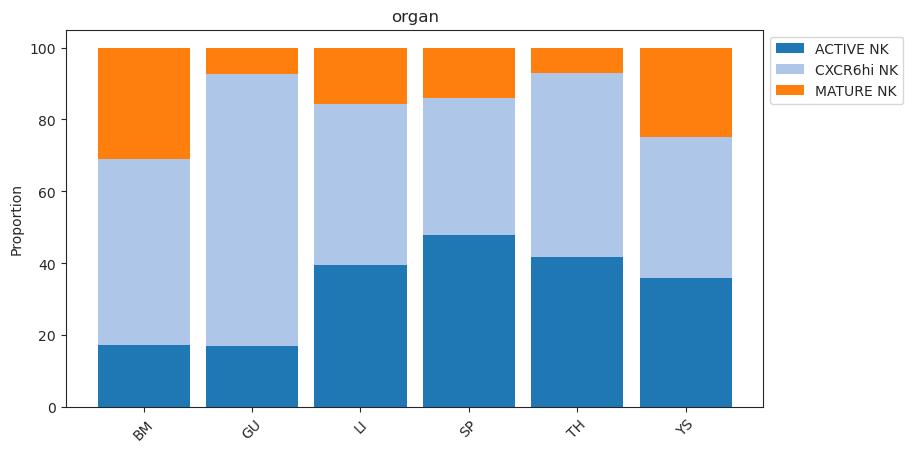

In [280]:
# Stacked barplot for the levels of "Condition"
viz.stacked_barplot(data_all[data_all.obs['Sort_id'] == 'CD45P'][:,NK_clusters], feature_name="organ")
plt.show()
viz.stacked_barplot(data_all[data_all.obs['Sort_id'] == 'TOT'][:,NK_clusters], feature_name="organ")
plt.show()

/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/sccoda/util/data_visualization.py:234: RuntimeWarning: invalid value encountered in true_divide
  X = data.X/sample_sums


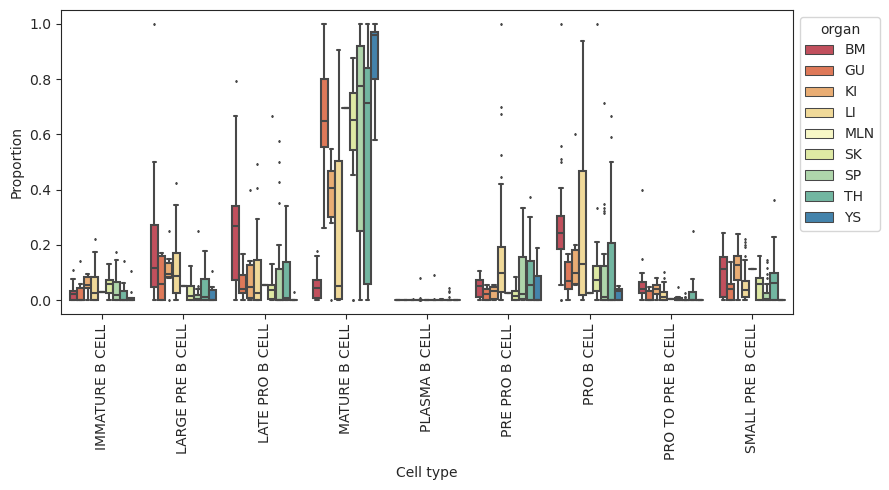

/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


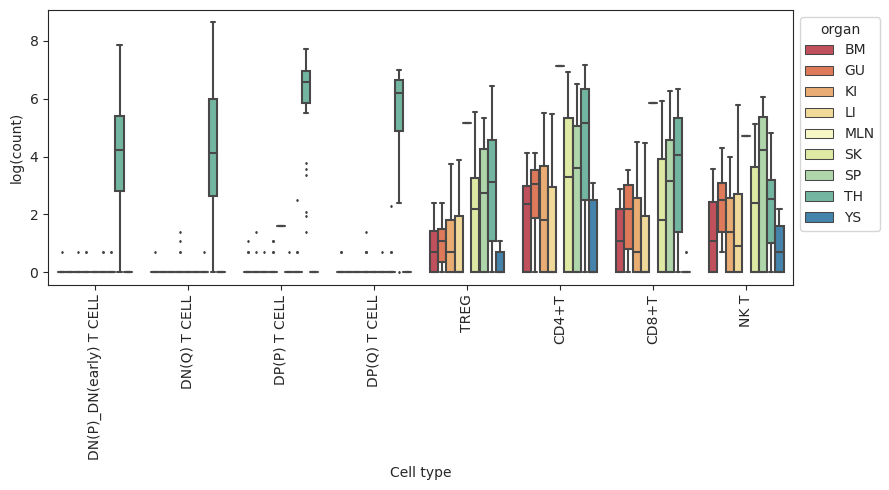

In [279]:
plt.rcParams["figure.figsize"] = [9,5]
viz.boxplots(
    data_all[:,B_clusters], feature_name="organ",
    plot_facets=False,
    add_dots=False,cmap="Spectral"
)
plt.show()
viz.boxplots(
    data_all[:,T_clusters], feature_name="organ",
    plot_facets=False,
    y_scale="log",
    add_dots=False,cmap="Spectral"
)
plt.show()

### Model setup

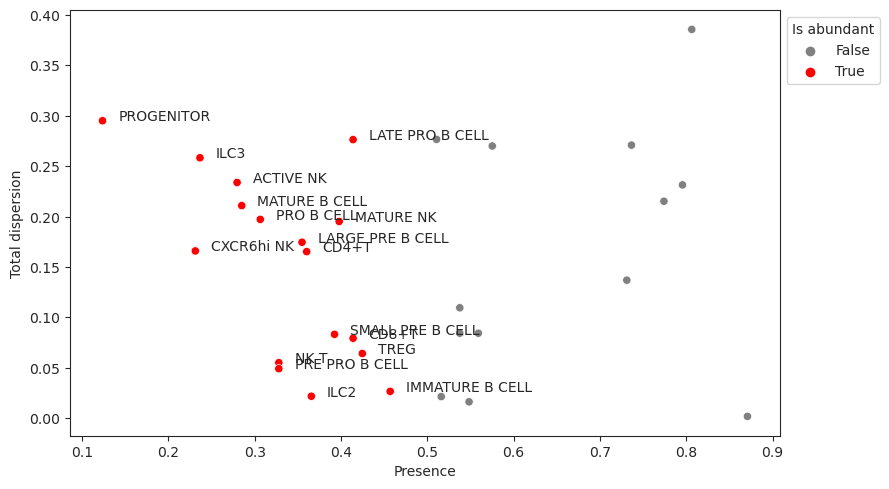

In [265]:
viz.rel_abundance_dispersion_plot(
    data=data_sorts,
    abundant_threshold=0.5
    )

plt.show()

### Encoding one-vs-rest

I want to compare the abundance of each cell type for each organ VS all the rest, while controlling for the sorting strategy.


In [227]:
test_org = "BM"
data_sorts.obs[test_org + "vs_rest"] = data_sorts.obs['organ'] == test_org

Trying to set attribute `.obs` of view, copying.


In [228]:
l = ["GU", "KI", "LI"]
model_organ = mod.CompositionalAnalysis(data_sorts, formula="0 + C(Sort_id,Treatment('TOT')) + " + test_org + "vs_rest", reference_cell_type='CXCR6hi NK')

Zero counts encountered in data! Added a pseudocount of 0.5.


In [229]:
model_organ.covariate_names

["C(Sort_id, Treatment('TOT'))[CD45P]",
 "C(Sort_id, Treatment('TOT'))[TOT]",
 'BMvs_rest[T.True]']

### Run MCMC

In [230]:
sim_results = model_organ.sample_hmc()

MCMC sampling finished. (222.962 sec)
Acceptance rate: 37.0%


/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/sccoda/util/result_classes.py:216: RuntimeWarning: Mean of empty slice.
  beta_nonzero_mean.append(beta_i_raw[beta_i_raw_nonzero].mean())
/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [231]:
res = sim_results.effect_df.reset_index()

In [240]:
sim_results.summary_extended()

Compositional Analysis summary (extended):

Data: 186 samples, 30 cell types
Reference index: 6
Formula: 0 + C(Sort_id,Treatment('TOT')) + BMvs_rest
Spike-and-slab threshold: 0.713

MCMC Sampling: Sampled 20000 chain states (5000 burnin samples) in 222.962 sec. Acceptance rate: 37.0%

Intercepts:
                        Final Parameter  HDI 3%  HDI 97%     SD  \
Cell Type                                                         
ACTIVE NK                        -0.811  -1.006   -0.649  0.109   
B1 CELL                          -1.096  -1.248   -0.940  0.083   
CD4+T                            -0.959  -1.144   -0.732  0.109   
CD8+T                            -0.934  -1.195   -0.619  0.154   
CD8aa                            -1.088  -1.232   -0.919  0.093   
CMP                              -0.236  -0.452   -0.064  0.112   
CXCR6hi NK                       -0.317  -0.433   -0.200  0.061   
DN(P)_DN(early) T CELL           -0.823  -1.099   -0.610  0.123   
DN(Q) T CELL                    

<AxesSubplot:xlabel='log2-fold change', ylabel='Final Parameter'>

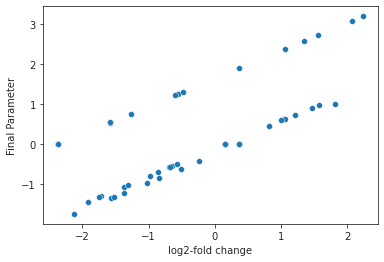

In [235]:
sns.scatterplot(data=res, x="log2-fold change", y="Final Parameter")

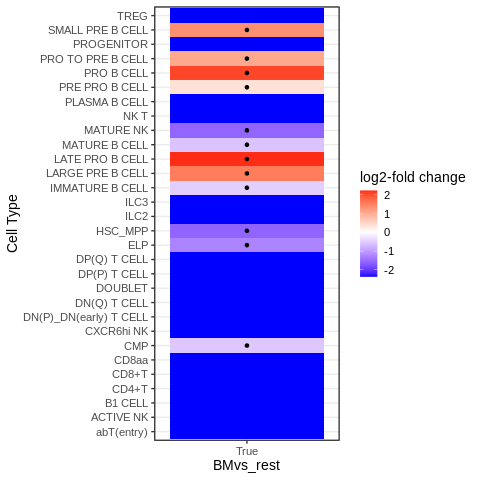

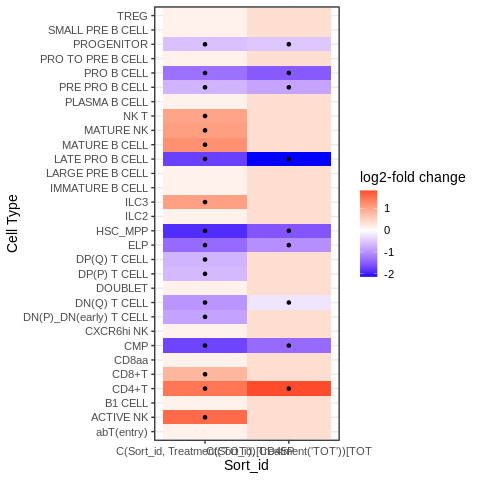

In [239]:
%%R -i res
sccoda_res <- res
keep_cov <- "organ"

plot_sccoda_res <- function(sccoda_res, keep_cov){
        sccoda_res %>%
    filter(str_detect(Covariate, keep_cov)) %>%
    mutate(cov=str_remove_all(Covariate, paste0(keep_cov, "\\[T.|\\]"))) %>%
    ggplot(aes(cov, `Cell Type`)) +
    geom_tile(aes(fill=`log2-fold change`)) +
    geom_point(data= . %>% filter(`Final Parameter` != 0)) +
    scale_fill_gradient2(high="red", low="blue") +
    xlab(keep_cov) +
    theme_bw(base_size=14)
}

print(plot_sccoda_res(sccoda_res, "BMvs_rest"))
print(plot_sccoda_res(sccoda_res, "Sort_id"))

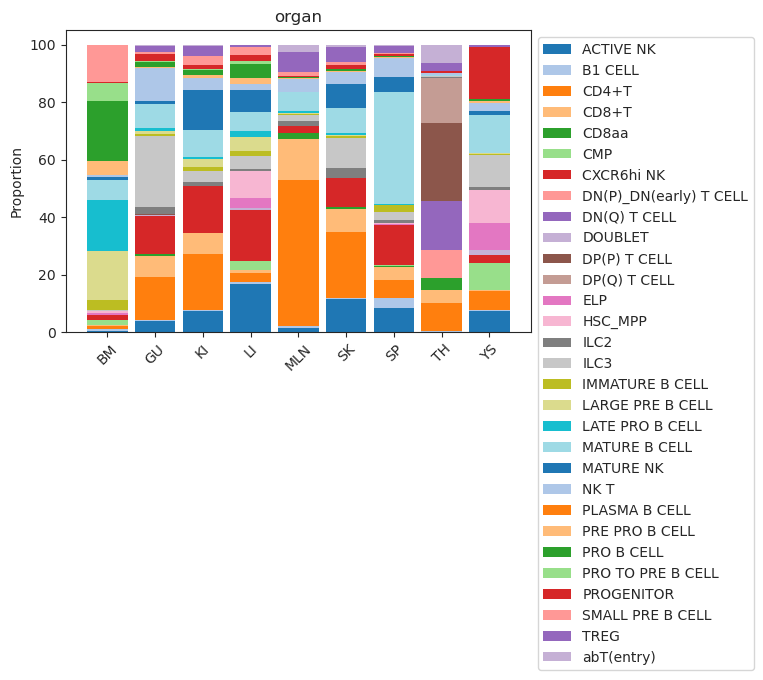

In [252]:
viz.stacked_barplot(data_all, feature_name="organ")
plt.show()